# Tutorial for solving the Schrödinger equation in 1D using Classical Splittings (`expsolve.splittings` and `expsolve.fourier`)

This notebook introduces you to the basic functionalities of `expsolve.splittings` with the example of the Schrödinger equation in 1D. 

*&#169; Copyright 2019-2022 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [1]:
import numpy as np
import scipy as sp
from scipy.sparse.linalg import expm
import matplotlib.pyplot as plt
import expsolve as es

# Classical splittings

In the solution of ODEs and PDEs

$$ u' = f(u), \qquad u(0)=u_0, \qquad \text{where}\quad  f = f_A + f_B $$

we often try to approximate the exact flow under the vector field $f$ with splitting and composition of the flows $f_A$ and $f_B$ which are easier to compute. 

Let $\Phi$ be the true flow under $f$, i.e. the solution of our ODE/PDE is given by 

$$ u(t+h) = \Phi_h\ u(t),$$

### Trotter splitting

The most basic splitting involves solving the ODE/PDE 

$$ u'=f_A(u), \qquad u(0) = u_0 $$

under $f_A$ alone for a step of $h$, obtaining $\tilde{u}$, and then solving the ODE/PDE

$$ u'=f_B(u), \qquad u(0) = \tilde{u} $$

under $f_B$ alone for a step of $h$, obtaining $u_1 \approx u(h)$ where $u(h)$ is the true solution. 

Speaking more formally, $\tilde{u} = \Phi_h^A\, u_0$ is obtained from $u_0$ under the flow of $f_A$, i.e. $\Phi_h^A$, and $u_1$ is obtained from $\tilde{u}$ under the flow of $f_B$, i.e. $\Phi_h^B$. Overall,

$$ u_1 = \Phi_h^B \circ \Phi_h^A\ u_0 $$

We say that the effective numerical flow is given by 

$$ \Phi_h^{(1),(1)} =  \Phi_h^B \circ \Phi_h^A $$

and the numerical method constitutes applying this flow for each time step

$$ u_{n+1} = \Phi_h^{(1),(1)}\ u_n $$

This method is the lowest order (order 1) splitting called the Trotter or Lie--Trotter splitting.


### Strang splitting

A more accurate (order 2) splitting is the Strang splitting, given by 

$$ \Phi_h^{(0, 1),(\frac12, \frac12)} =  \Phi_{\frac{h}{2}}^B \circ \Phi_h^A \circ \Phi_{\frac{h}{2}}^B$$

### General (classical) splitting

In general, a splitting takes the following form:

$$ \Phi_h^{\alpha,\beta} =  \prod_{k=1}^{K} \Phi_{h \beta_k}^B \circ \Phi_{h \alpha_k}^A $$

where $\alpha$ and $\beta$ are vectors of length $K$ each. Note that the above product needs to be ordered since the product is not-abelian. We assume the convention 

$$ \prod_{k=1}^{K} \Phi_{h \beta_k}^B \circ \Phi_{h \alpha_k}^A \ = \ \Phi_{h \beta_K}^B \circ \Phi_{h \alpha_K}^A \circ \ldots \circ  \Phi_{h \beta_2}^B \circ \Phi_{h \alpha_2}^A \Phi_{h \beta_1}^B \circ \Phi_{h \alpha_1}^A $$

Some components of $alpha$ and $\beta$ may be $0$. If intermediate components, i.e. $\alpha_k$ for $1<k<K$ is $0$, the neighbouring $B$ (or, appropriately, $A$ in case of zero $\beta_k$) flows can be combined, and the splitting can be made shorter. Therefore, without loss of generality, we may assume no intermediate component is $0$. The total number of non-zero components ($\leq 2K$) in the splitting are called the number of *stages* (each stage represents an ODE/PDE solve). 


### Exponential splitting

In the case of a linear ODE/PDE,

$$ u' = (A+B) u, $$ 

the flows $\Phi_h^A$ and $\Phi_h^B$ are given by the matrix (or operator in case of PDE) exponentials,

$$ \Phi_h^A\ v= \exp(h A)\, v, \qquad \Phi_h^B\ v= \exp(h B)\, v $$

The Trotter splitting takes the form

$$ u_1 = \exp(h B)  \exp(h A)\ u_0 $$

or 

$$ \exp(h (A+B)) \approx \Phi_h^{(1),(1)} = \exp(h B)  \exp(h A) $$

The Strang splitting takes the form 

$$ u_1 = \exp\left(\frac{h}{2} B \right)  \exp(h A) \exp\left(\frac{h}{2} B \right) \ u_0 $$

or 

$$ \exp(h (A+B)) \approx \Phi_h^{(0, 1),(\frac12, \frac12)} = \exp\left(\frac{h}{2} B \right)  \exp(h A) \exp\left(\frac{h}{2} B \right) $$

and in general, a classical splitting defined by the vectors $\alpha$ and $\beta$ takes the form

$$ \exp(h (A+B)) \approx \prod_{k=1}^{K} \exp\left(h \beta_k B\right)\ \exp\left(h \alpha_k A \right)  \ = \ \exp\left(h \beta_K B\right) \exp\left(h \alpha_K A \right)  \ldots  \left(h \beta_2 B\right) \exp\left(h \alpha_2 A \right) \exp\left(h \beta_1 B\right) \exp\left(h \alpha_1 A \right)  $$

The matrix/operator exponentials may be computed exactly or further approximated, e.g. using methods such as Krylov subspace methods. 

# Solving the Schrödinger equation

The linear time-dependent Schrödinger equation in 1D with periodic boundaries over a domain $[-L,L]$ can be written as

$$ i \partial_t \psi(x,t) = \mathrm{H} \psi(x,t), \qquad x \in [-L,L] $$

where $\mathrm{H}$ is the Hamiltonian operator

$$ \mathrm{H} = -\partial_x^2 + V(x) $$

and $V(x)$ is a (typically real-valued) potential function. Typically, we spatially discretise the PDE, replacing the Hamiltonian operator $\mathrm{H}$ with a discretised Hamiltonian matrix $\mathbf{H}$, and arriving at the system of ODEs:

$$ i \partial_t u(t) = \mathbf{H} u(t), $$

where $u(t)$ is now a vector of values on the spatial grid, and the discretised Hamiltonian matrix is

$$ \mathbf{H} = -\mathrm{D}_2 + \texttt{diag}(V). $$

The exact solution of this system of ODEs is given by the matrix exponential:

$$ u(t) = \exp\left(-i t \mathbf{H}\right) u(0). $$

## The splitting approach for solving the Schrödinger equation

The splitting approach is to approximate the matrix exponential in 

$$ u(t) = \exp\left(-i t \mathbf{H}\right) u(0) $$

as 

$$ \exp\left(-i h\, \mathbf{H}\right) \quad = \quad \exp\left(i h\, \mathbf{D}_2 - i h\, \texttt{diag}(V) \right) \quad \approx \quad \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i h\, \texttt{diag}(V) \right) $$

which is the 1st order approximation given by the Trotter splitting (and h is the time step) or as

$$ \exp\left(-i h\, \mathbf{H}\right) \quad = \quad \exp\left(i h\, \mathbf{D}_2 - i h\, \texttt{diag}(V) \right) \quad \approx \quad \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) $$

which is the 2nd order approximation given by the Strang splitting.

The overall numerical scheme (in the case of the Strang splitting) is:

$$ u_{n+1} = \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) u_n $$

Splitting is useful because we can compute the exponentials of $\texttt{diag}(V)$ and $\mathbf{D}_2$ much more cheaply separately than we can compute the exponential when they are combined in the full discrestised $\mathbf{H}$. For instance, the computation of the exponential of $\mathbf{H}$ using `expm` costs $\mathcal{O}\left(n^3\right)$ operations. On the other hand, expoential of $\texttt{diag}(V)$ can be computed in a pointwise way in $\mathcal{O}(n)$ operations, while exponential of $\mathbf{D}_2$ costs us $\mathcal{O}(n \log n)$ operations. The latter is because the Fourier differentiation matrices in `expsolve.fourier` can be diagonalised with the Fourier transform:

$$ \mathbf{D}_k = \mathcal{F}^{-1} \texttt{diag}(s_k) \mathcal{F} $$
where $s_k$ is the symbol of $\mathbf{D}_k$ (in particular, the $j$ th component of $s_k$ is $(s_k)_j = (-i j \pi)^k$). 

In `expsolve.fourier`, the function `diffop` computes the action of $\mathbf{D}_k$ on vector `u` as 

$$ \mathbf{D}_k = \mathcal{F}^{-1} \texttt{diag}(s_k) \mathcal{F} u = \texttt{ifft}\left(s_k\ \texttt{fft}(u) \right) $$

in $\mathcal{O}(n \log n)$ operations. This is why `diffop` is preferred to `diffmatrix` followed by matrix-vector multiplication, which costs $\mathcal{O}(n^2)$ cost and storage.

We can easily see that 

$$ \left(\mathbf{D}_k\right)^n = \mathcal{F}^{-1} \texttt{diag}((s_k)^n) \mathcal{F} $$

With the help of Taylor expanion, we can also seee that exponential of $\mathbf{D}_k$ is

$$ \exp(c \mathbf{D}_k) = \mathcal{F}^{-1} \texttt{diag}(\exp(c s_k)) \mathcal{F} $$

for any $c \in \mathbb{C}$, and it's action on a vector $u$ is computed in $\mathcal{O}(n \log n)$ operations as 

$$ \exp(c \mathbf{D}_k) u= \mathcal{F}^{-1} \texttt{diag}(\exp(c s_k)) \mathcal{F} u = \texttt{ifft}\left( \exp(c s_k) \texttt{fft}(u) \right) .$$

This functionality is implemented in the function `diffopexp`, whose syntax is:


```Python
    eDu = expsolve.fourier.diffopexp(j, k, c, u, xrange) 
```
which computes $\exp(c D_{j,k}) u$, where `u` is the vector of values on a periodic grid defined on the domain `xrange`, $D_{j,k}$ is the $k$ th differentiation operator in the $j$ th direction. 

* Since we are working in 1D here, $j=0$. 
* Since we need 2nd derivative, $k=2$. 

### Grid & Initial Condition

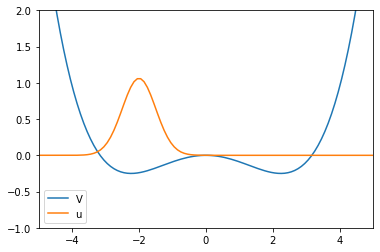

In [2]:
n = 200
L = 10
xr = [-L, L]
x = es.fourier.grid1d(n, xr)

x0 = -2.0
u = np.exp(-(x-x0)**2/(2*0.25))

u = u/es.fourier.l2norm(u, xr)

V = x**4 - 10*x**2

plt.plot(x, V/100)
plt.plot(x, u)
plt.xlim(-5,5)
plt.ylim(-1,2)
plt.legend(['V','u'])
plt.show()

### Strang splitting

We create lambda functions for computing $\exp(i h D_2) u$ and $\exp(-i h \texttt{diag}(V)) u$, and compose them to form a single step of Strang:

$$\exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) u_n $$

In [3]:
eLu = lambda t, tauV, h, c, u: es.fourier.diffopexp(0, 2, 1j*c*h, u, xr)
eVu = lambda t, tauL, h, c, u: np.exp(-1j*c*h*V)*u

strangalpha, strangbeta = es.splittings.classical.symmetric([],[])
print(strangalpha, strangbeta)

strangstep = lambda t, h, u0: es.splittings.classical.stepper(t, h, u0, eVu, eLu, strangalpha, strangbeta)

[0.5, 0.5] [1.0, 0]


For now ignore `tauL` and `tauV`. These are used in time-ordered propagation for time-dependent Hamiltonians, an example for which appears towards the end of this notebook. We also ignore `t` in this implementation since the Hamiltonian is time-independent. 

Once the stepper is ready, we can use `expsolve.evolve` to simulate over $[0,T]$

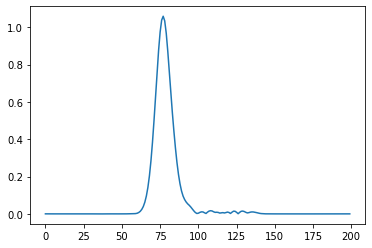

In [6]:
T = 1
N  = 10

ustrangT = es.evolve(u, es.timegrid(T, 10), strangstep)[0]

plt.plot(np.abs(ustrangT))
plt.show()

Let's check the error compared to the brute force solution obtained by `expm`

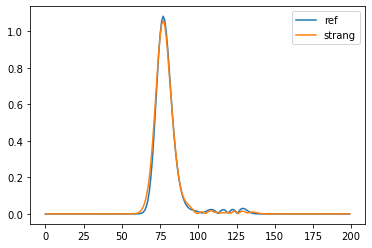

The L2 error in Strang splitting is 0.1881923321770154


In [7]:
D2 = es.fourier.diffmatrix(2, n, xr)
H = -D2 + np.diag(V)
urefT = expm(-1j*T*H).dot(u)

plt.plot(np.abs(urefT))
plt.plot(np.abs(ustrangT))
plt.legend(['ref','strang'])
plt.show()

print(f'The L2 error in Strang splitting is {es.fourier.l2norm(urefT-ustrangT, xr)}')

### Analysing order of Strang

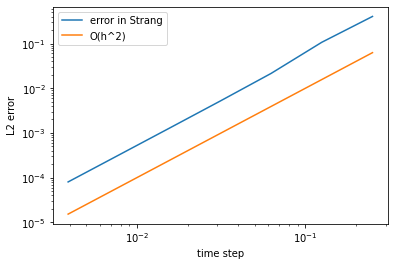

In [8]:
Nlist = 2**np.arange(2,9)
hlist = T/Nlist

err = [es.fourier.l2norm(urefT-es.evolve(u, es.timegrid(T, N), strangstep)[0]) for N in Nlist]

plt.loglog(hlist, err)
plt.loglog(hlist, hlist**2)
plt.xlabel('time step')
plt.ylabel('L2 error')
plt.legend(['error in Strang', 'O(h^2)'])
plt.show()

As we can see, the (global) error of Strang is $\mathcal{O}(h^2)$.

### Trotter splitting

Trotter splitting is the most trivial splitting. It is easily implemented:

In [9]:
trotteralpha, trotterbeta = es.splittings.classical.consistent([],[])
print(trotteralpha, trotterbeta)

trotterstep = lambda t, h, u0: es.splittings.classical.stepper(t, h, u0, eVu, eLu, trotteralpha, trotterbeta)

[1.0] [1.0]


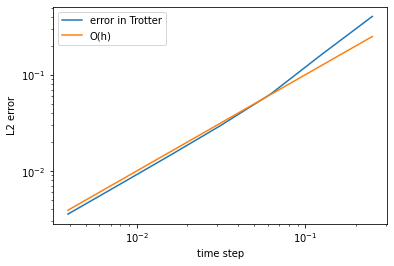

In [10]:
Nlist = 2**np.arange(2,9)
hlist = T/Nlist

err = [es.fourier.l2norm(urefT-es.evolve(u, es.timegrid(T, N), trotterstep)[0]) for N in Nlist]

plt.loglog(hlist, err)
plt.loglog(hlist, hlist)
plt.xlabel('time step')
plt.ylabel('L2 error')
plt.legend(['error in Trotter', 'O(h)'])
plt.show()

As we can see, the (global) error of Trotter is $\mathcal{O}(h)$.

### Blanes-Moan Order 4

$$
a_1 = 0.0792036964311957, \quad
b_1 = 0.209515106613362, \quad
a_2 = 0.353172906049774, \quad
b_2 = −0.143851773179818, \quad
a_3 = −0.0420650803577195
$$

and 

$$ b_3 = 1/2 − b_1 − b_2, \qquad 
a_4 = 1 − 2(a_1 + a_2 + a_3),$$

In [11]:
a = np.array([0.0792036964311957, 0.353172906049774, -0.0420650803577195])
b = np.array([0.209515106613362, -0.143851773179818])
blanesmoanalpha, blanesmoanbeta = es.splittings.classical.symmetric(a,b)
print(blanesmoanalpha, blanesmoanbeta)

[0.0792036964311957, 0.353172906049774, -0.0420650803577195, 0.21937695575349958, -0.0420650803577195, 0.353172906049774, 0.0792036964311957] [0.209515106613362, -0.143851773179818, 0.434336666566456, 0.434336666566456, -0.143851773179818, 0.209515106613362, 0]


In [12]:
blanesmoanstep = lambda t, h, u0: es.splittings.classical.stepper(t, h, u0, eVu, eLu, blanesmoanalpha, blanesmoanbeta)

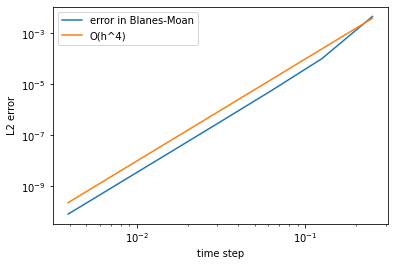

In [13]:
Nlist = 2**np.arange(2,9)
hlist = T/Nlist

err = [es.fourier.l2norm(urefT-es.evolve(u, es.timegrid(T, N), blanesmoanstep)[0]) for N in Nlist]

plt.loglog(hlist, err)
plt.loglog(hlist, hlist**4)
plt.xlabel('time step')
plt.ylabel('L2 error')
plt.legend(['error in Blanes-Moan', 'O(h^4)'])
plt.show()

### Computing Observables

Recall that observables are implemented using the `observable` function, the syntax of which is:

```Python
    es.fourier.observable(O, u, xrange)
```
where `u` is the vector of values on a periodic grid defined on the domain `xrange`, and `O` is a Hermitian operator or matrix. 

For instance, the position operator is multiplication by $x$ which is achieved as `lambda psi: x*psi` and the momentum operator is multiplication by $-i$ and 1st derivative operation. Let us put these in a dictionary:

In [14]:
observables = {'energy': lambda u: es.fourier.observable(lambda psi: -es.fourier.diffop(0, 2, psi, xr) + V*psi, u, xr), 
'position': lambda u: es.fourier.observable(lambda psi: x*psi, u, xr), 
'momentum': lambda u: es.fourier.observable(lambda psi: 1j*es.fourier.diffop(0, 1, psi, xr), u, xr), 
'kinetic': lambda u: es.fourier.observable(lambda psi: -es.fourier.diffop(0, 2, psi, xr), u, xr), 
'potential':lambda u: es.fourier.observable(lambda psi: V*psi, u, xr)}

In [15]:
T = 1
N = 1000
timegrid = es.timegrid(T, N)

In [16]:
trotterevolve = es.evolve(u, timegrid, trotterstep, observables)
strangevolve = es.evolve(u, timegrid, strangstep, observables)
blanesmoanevolve = es.evolve(u, timegrid, blanesmoanstep, observables)

In [17]:
obsvalues_trotter = trotterevolve[1]
obsvalues_strang = strangevolve[1]
obsvalues_blanesmoan = blanesmoanevolve[1]

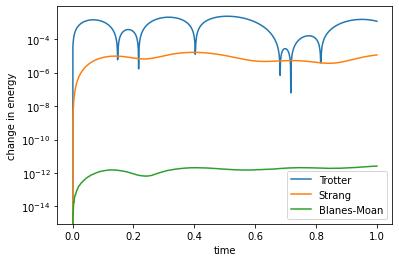

In [30]:
plt.figure()

E0 = obsvalues_trotter['energy'][0]

plt.semilogy(timegrid, np.abs(obsvalues_trotter['energy']-E0))
plt.semilogy(timegrid, np.abs(obsvalues_strang['energy']-E0))
plt.semilogy(timegrid, np.abs(obsvalues_blanesmoan['energy']-E0))
plt.legend(['Trotter','Strang','Blanes-Moan'])
plt.ylabel('change in energy')
plt.xlabel('time')
plt.show()

Splittings do not conserve energy exactly!

Other observables:

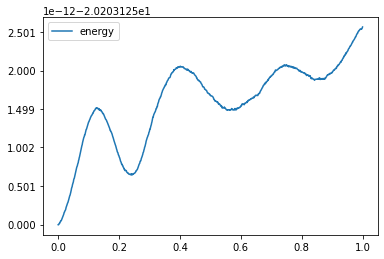

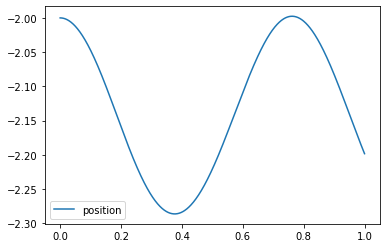

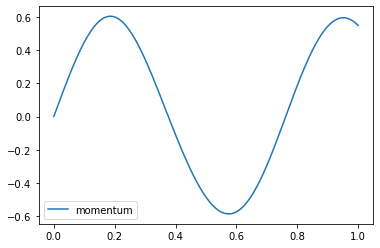

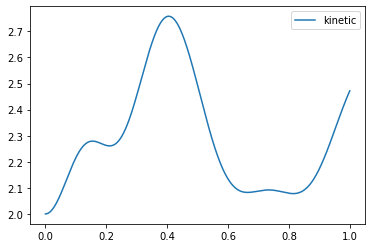

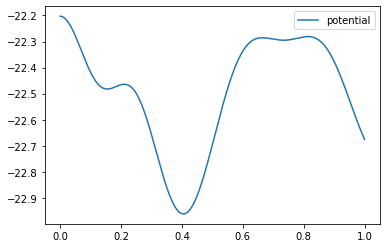

In [19]:
for o in observables:
    ov = obsvalues_blanesmoan[o]
    plt.figure()
    plt.plot(timegrid, ov)   
    plt.legend([o])
    plt.show()

# Time-dependent potential 

The linear time-dependent Schrödinger equation in 1D with with time-dependent Hamiltonian can be written in the following form

$$ i \partial_t \psi(x,t) = \mathrm{H}(t) \psi(x,t), \qquad x \in [-L,L] $$

We consider explicitly time-dependent Hamiltonian operators $\mathrm{H}(t)$ of the form

$$ \mathrm{H} = -\partial_x^2 + V(x,t) $$

e.g. 

$$ V(x,t) = V_0(x) + c_1 e^{-\frac{(x-(x_0+t)).^2}{2\sigma^2}}\sin(8 \pi (x-t)) - c_2 \sin(5 \pi t)x $$

for $x_0 = -2$, $c_1 = c_2 = 10^2$, $\sigma = 0.5$.

We can implement this using a classical splitting by introducing an internal time that advances with each action of $-\partial_x^2$. 

Specifically, we compute

$$u_{n+1} = \exp\left(- i h \beta_K V(\tau_K) \right) \exp\left(i h \alpha_K\, \mathbf{D}_2\right) \ldots \exp\left(- i h \beta_2 V(\tau_2) \right) \exp\left(i h \alpha_2\, \mathbf{D}_2\right) \exp\left(- i h \beta_1 V(\tau_1) \right) \exp\left(i h \alpha_1\, \mathbf{D}_2\right)u_n $$

where 

$$ \tau_k = \tau_{k-1} + \alpha_k, \qquad \tau_0 = t_n $$

In [20]:
sigma = 0.5
c1 = 1e2
c2 = 1e2
x0 = -2

In [21]:
Vt = lambda t : V + c1 * np.exp(-(x-(x0+t))**2/(2*sigma)) * np.sin(8*np.pi*(x-t)) - c2 * np.sin(5*np.pi*t) * x

In [22]:
eLu = lambda t, tauV, h, c, u: es.fourier.diffopexp(0, 2, 1j*c*h, u, xr)
eVtu = lambda t, tauL, h, c, u: np.exp(-1j*c*h*Vt(tauL))*u

In [23]:
trotterstep_Vt = lambda t, h, u0: es.splittings.classical.stepper(t, h, u0, eVtu, eLu, trotteralpha, trotterbeta)
strangstep_Vt = lambda t, h, u0: es.splittings.classical.stepper(t, h, u0, eVtu, eLu, strangalpha, strangbeta)
blanesmoanstep_Vt = lambda t, h, u0: es.splittings.classical.stepper(t, h, u0, eVtu, eLu, blanesmoanalpha, blanesmoanbeta)

In [24]:
trotterevolve_Vt = es.evolve(u, timegrid, trotterstep_Vt, observables)
strangevolve_Vt = es.evolve(u, timegrid, strangstep_Vt, observables)
blanesmoanevolve_Vt = es.evolve(u, timegrid, blanesmoanstep_Vt, observables)

obsvalues_trotter_Vt = trotterevolve_Vt[1]
obsvalues_strang_Vt = strangevolve_Vt[1]
obsvalues_blanesmoan_Vt = blanesmoanevolve_Vt[1]

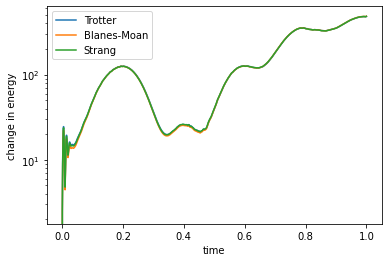

In [25]:
plt.figure()

E0 = obsvalues_trotter['energy'][0]

plt.semilogy(timegrid, np.abs(obsvalues_trotter_Vt['energy']-E0))
plt.semilogy(timegrid, np.abs(obsvalues_strang_Vt['energy']-E0))
plt.semilogy(timegrid, np.abs(obsvalues_blanesmoan_Vt['energy']-E0))
plt.legend({'Trotter','Strang','Blanes-Moan'})
plt.ylabel('change in energy')
plt.xlabel('time')
plt.show()

The energy is no longer conserved! That's because we have a time-dependent Hamiltonian now.

## Reference solution

This time around, the brute force solution is very expensive. We compute by sampling $H(t)$ at midpoint $t+\frac{h}{2}$ and exponentiating via `expm`.

### Warning: will take 5-10 minutes

In [26]:
Ht = lambda t, h: -D2 + np.diag(Vt(t+h/2))

T = 0.1         # reference too expensive and inaccurate for large T
Nref = 10000

ureft = u
h = T/Nref
t = 0.
for k in range(Nref+1):
    ureft = expm(-1j*h*Ht(t,h)).dot(ureft)
    t = t + h

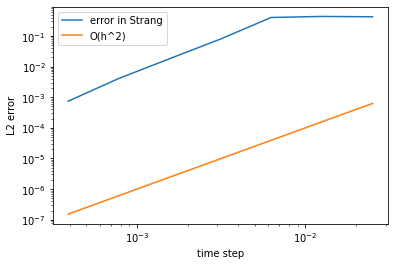

In [27]:
Nlist = 2**np.arange(2,9)
hlist = T/Nlist

err = [es.fourier.l2norm(ureft-es.evolve(u, es.timegrid(T, N), strangstep_Vt)[0]) for N in Nlist]

plt.loglog(hlist, err)
plt.loglog(hlist, hlist**2)
plt.xlabel('time step')
plt.ylabel('L2 error')
plt.legend(['error in Strang', 'O(h^2)'])
plt.show()

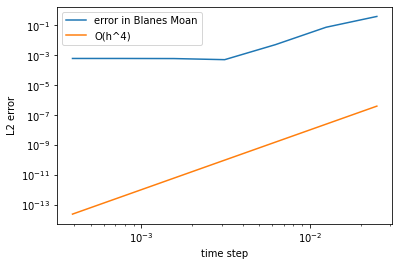

In [28]:
Nlist = 2**np.arange(2,9)
hlist = T/Nlist

err = [es.fourier.l2norm(ureft-es.evolve(u, es.timegrid(T, N), blanesmoanstep_Vt)[0]) for N in Nlist]

plt.loglog(hlist, err)
plt.loglog(hlist, hlist**4)
plt.xlabel('time step')
plt.ylabel('L2 error')
plt.legend(['error in Blanes Moan', 'O(h^4)'])
plt.show()

The problem with Blanes-Moan is that the reference is not accurate enough. We can do self referencing instead to check rate of convergence:

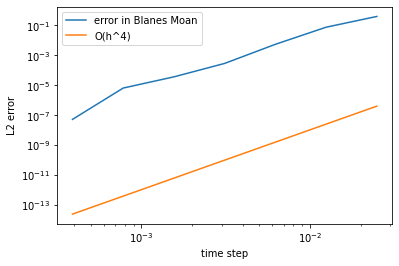

In [29]:
Nlist = 2**np.arange(2,9)
hlist = T/Nlist

uref_blanesmoan = es.evolve(u, es.timegrid(T, 10000), blanesmoanstep_Vt)[0]

err = [es.fourier.l2norm(uref_blanesmoan-es.evolve(u, es.timegrid(T, N), blanesmoanstep_Vt)[0]) for N in Nlist]

plt.loglog(hlist, err)
plt.loglog(hlist, hlist**4)
plt.xlabel('time step')
plt.ylabel('L2 error')
plt.legend(['error in Blanes Moan', 'O(h^4)'])
plt.show()